This tutorial can be downloaded [link](http://greatfire.uchicago.edu/west-public/West/raw/master/Doc/tutorials/advanced/advanced_002.ipynb).

# Advanced tutorial 2: Detailed analysis of the QDET many-body states

In this tutorial, we show how the full diagonalization of effective Hamiltonian in QDET enables a detailed analysis of the excited defect states.

As we focus on the analysis in this tutorial, we download the input and output files from the QDET calculation. For more details how to perform the underlying QDET calculations, see [Basic Tutorial 5](http://greatfire.uchicago.edu/west-public/West/raw/master/Doc/tutorials/basic/basic_005.ipynb).

In [ ]:
%%bash
mkdir -p west.wfreq.save
wget -N -q http://www.west-code.org/doc/training/nv_diamond_63/wfreq.in
wget -N -q http://www.west-code.org/doc/training/nv_diamond_63/wfreq.json -O west.wfreq.save/wfreq.json

We diagonalize the QDET Hamiltonian as usual:

In [4]:
from westpy.qdet import QDETResult

# construct object for effective Hamiltonian
effective_hamiltonian = QDETResult(filename='west.wfreq.save/wfreq.json')

# diagonalize Hamiltonian
solution = effective_hamiltonian.solve()

-----------------------------------------------------
Building effective Hamiltonian...
nspin: 1
occupations: [[2. 2. 2. 2. 1. 1.]]


diag[1RDM - 1RDM(GS)]                                 
  E [eV] char                    87    122    123    126   127   128
0  0.000   3-                 0.000  0.000  0.000  0.000 0.000 0.000
1  0.436   1-                -0.001 -0.009 -0.018 -0.067 0.037 0.058
2  0.436   1-                -0.001 -0.009 -0.018 -0.067 0.058 0.037
3  1.250   1-                -0.002 -0.019 -0.023 -0.067 0.056 0.055
4  1.941   3-                -0.003 -0.010 -0.127 -0.860 0.000 1.000
5  1.941   3-                -0.003 -0.010 -0.127 -0.860 1.000 0.000
6  2.937   1-                -0.000 -0.032 -0.043 -0.855 0.110 0.821
7  2.937   1-                -0.000 -0.033 -0.043 -0.855 0.821 0.110
8  4.662   1-                -0.005 -0.055 -0.188 -1.672 0.960 0.960
9  5.073   3-                -0.014 -0.702 -0.209 -0.075 0.000 1.000

-----------------------------------------------------


We now need to extract two important parameters: the number of orbitals that form the active space, and the number of electrons in the active space. Those together define how many Slater determinants can be constructed within the active space.

In [7]:
import numpy as np

# number of orbitals that form the active space
norb = len(effective_hamiltonian.basis)
print('norb =', norb)

# number of electrons in each spin-channel
n = np.sum(effective_hamiltonian.occupation)
nelec = (int(round(n)) // 2, int(round(n)) // 2)
print('nelec = ', nelec)

norb = 6
nelec =  (5, 5)


We can now print the number of Slater determinants in each channel. Since we want to calculate both singlet and triplet states, we typically use the same number of electrons in each spin channel (i.e. we calculate $M_S=1$ states). We thus obtain the same number of Slater determinants in the up- and down-channel.

In [9]:
from pyscf.fci import cistring

# print the number of possible Slater determinants in each spin channel
for spin in range(2):
    print('No. of Slater determinants in channel', spin, ':',
          len(cistring.make_strings(range(norb),nelec[spin])))

No. of Slater determinants in channel 0 : 6
No. of Slater determinants in channel 1 : 6


The eigenstate of each many-body state is a matrix of size (No. of Slater determinants up, No. of Slater determinants down), where each entry represents the contribution of that product of Slater determinants to the many-body states.

In [10]:
print(solution['evcs'][0].shape)

(6, 6)


We can now inspect the contribution of the various Slater determinants to a given excited many-body state.

<IPython.core.display.Javascript object>


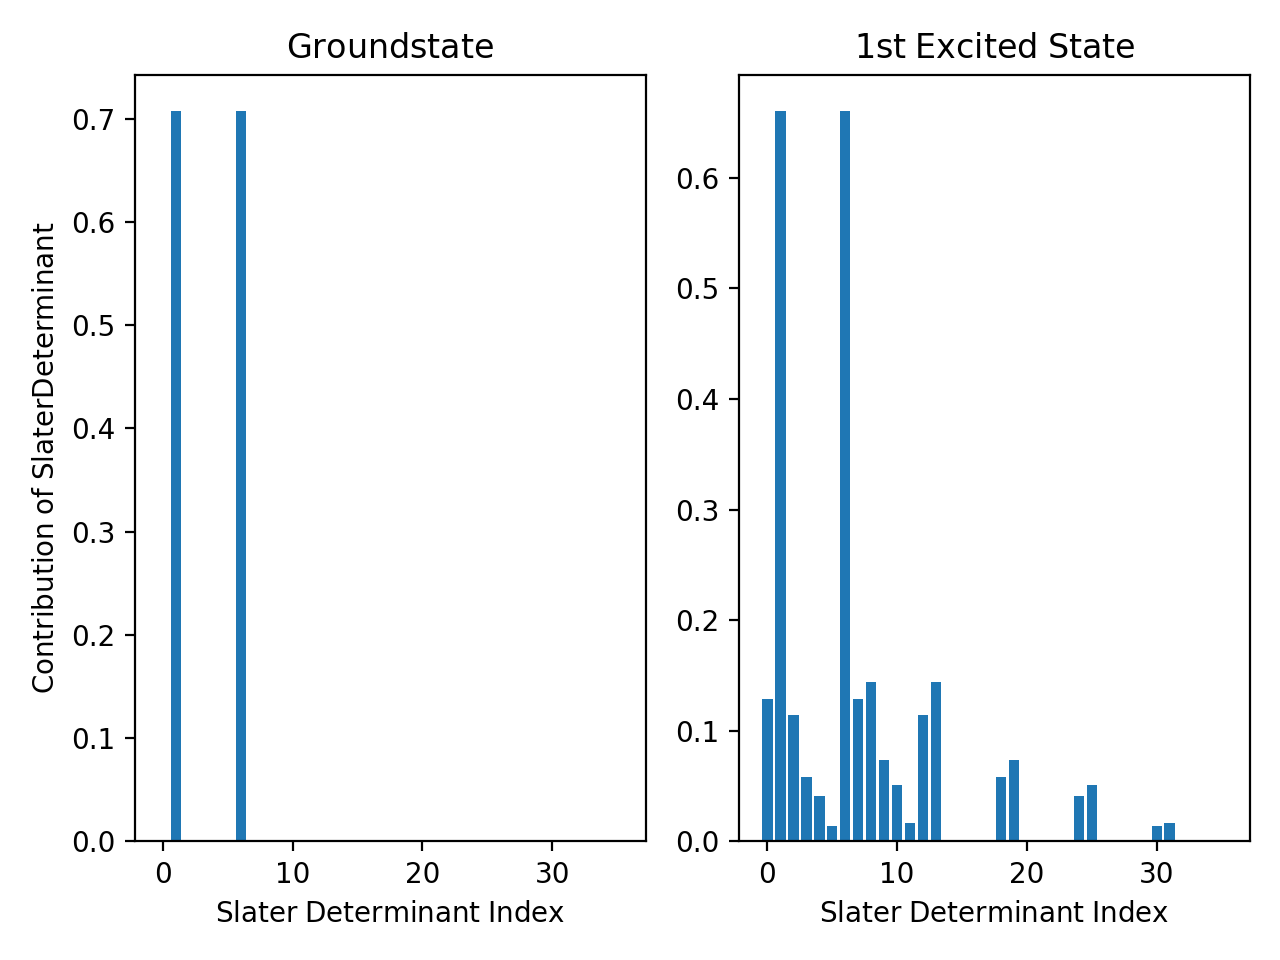

In [13]:
import matplotlib.pyplot as plt
%matplotlib notebook

index1 = 0
index2 = 1

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title(r'$\mathrm{Groundstate}$')
ax2.set_title(r'$\mathrm{1st \; Excited \; State}$')

ax1.set_xlabel(r'$\mathrm{Slater \; Determinant \; Index}$')
ax1.set_ylabel(r'$\mathrm{Contribution \; of \; Slater Determinant}$')

ax2.set_xlabel(r'$\mathrm{Slater \; Determinant \; Index}$')


ax1.bar([i for i in range(solution['evcs'][index1].flatten().shape[0])],
        abs(solution['evcs'][index1].flatten()))

ax2.bar([i for i in range(solution['evcs'][index2].flatten().shape[0])],
        abs(solution['evcs'][index2].flatten()))

plt.tight_layout()
plt.show()

We can see that only two Slater determinants contribute to the ground state. To see which ones these are, let's print the many-body state explicitely:

In [14]:
from westpy.qdet import visualize_correlated_state

print(visualize_correlated_state(solution['evcs'][0], norb, nelec, cutoff=10 **(-3)))

-0.707|011111>|101111>+0.707|101111>|011111>


The state is a linear contribution of products of two Slater determinants, such as $|011111\rangle| 101111\rangle$, where the first one ($|011111\rangle$) is the Slater determinant in the up-channel, and the second one  ($|101111\rangle$) is the determinant in the down-channel.

Slater determinants are in the Fock-representation, where the orbitals with the lowest energy is on the right. For example, $|011111\rangle$ means that the 5 orbitals with lowest energy are occupied and the orbital with highest energy is unoccupied.

Finally, the `cutoff` in `visualize_correlated_state` is the cutoff for Slater determinants. Only Slater determinants with prefactors larger than the cutoff are printed.